<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Skin Cancer Detection

> Authors: Cher Wee Zheng, Ng Wei, Ryan Yong

**Summary:**   
- Develop a Neural Network model to differentiate whether the skin abnormality in the image is malignant or benign .
- Training data: Malignant and Benign samples

There are a total of 4 notebooks for this project:  
 1. `01_EDA.ipynb`   
 2. `02_Data_Modelling.ipynb`   
 3. `03_Hyperparameter_Tuning.ipynb`  

---
**This Notebook**
- In this notebook, the model was attempted to be tuned. However, the tuned model proved to be slightly unstable with inconsistent results. Therefore for the streamlit app, the original un-tuned model will be used instead.

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.base import BaseEstimator


import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Set Original Training and Test Directories
train_dir = '../data/train'
test_dir = '../data/test'

# Set directories for training and validation data
train_data_dir = '../data/train_data'
validation_data_dir = '../data/validation_data'

# Set image size (img_size) and number of classes (num_class)
img_size = (128,128)
num_classes = 2


For training data, the images will be augmented slightly similar to model evaluation to ensure model is able to generalize the data and reduce overfitting

In [ ]:
# Prepare the data generators for training and validation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

A function to create the Sequential model is made here for RandomSearchCV

In [ ]:
def create_model(learning_rate, img_size, num_classes):
    # Create the CNN model
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

Below an attempt to use Object Oriented Programme was made to simulate a Keras Wrapper. This is because when attempting to import keras wrapper from tf.keras, the wrapper did not seem to either load correctly or was not usable.

In [ ]:
class KerasEstimator(BaseEstimator):
    def __init__(self, learning_rate, epochs, img_size, num_classes):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.img_size = img_size
        self.num_classes = num_classes
    
    def fit(self, X):
        train_generator, validation_generator, batch_size = X
        
        self.model = create_model(self.learning_rate, self.img_size, self.num_classes)
        
        self.model.fit(
            train_generator,
            batch_size = batch_size,
            validation_data=validation_generator,
            epochs=self.epochs
        )
        
        return self

The class however was unable to make a function for scoring that worked, thus for the random search later on, the assessment will be done manually based on validation accuracy.

In [ ]:
# Generate training and validation data using data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)
batch_size = 32

# Define the hyperparameter space for random search
param_dist = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'epochs': [5, 10,20]
}

# Create an instance of the KerasEstimator
estimator = KerasEstimator(learning_rate=None, epochs=None, img_size=img_size, num_classes=num_classes)

RandomSearchCV performed below for 6 iterations with 9 possibilities.

In [31]:
# Perform random search
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_dist,
    n_iter=6,
    cv=[(slice(None), slice(None))],  # Use the entire dataset for each iteration
    verbose=2,
    scoring='accuracy'
)

random_search.fit(
    X=(train_generator, validation_generator, batch_size), X_2 = test_generator
)

# Print the best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Found 9503 images belonging to 2 classes.
Found 2376 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Fitting 1 folds for each of 6 candidates, totalling 6 fits
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 192ms/step - accuracy: 0.6881 - loss: 8.2369 - val_accuracy: 0.8161 - val_loss: 0.4103
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.8027 - loss: 0.4358 - val_accuracy: 0.7971 - val_loss: 0.4319
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 191ms/step - accuracy: 0.8091 - loss: 0.4181 - val_accuracy: 0.8300 - val_loss: 0.3726
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - accuracy: 0.8260 - loss: 0.3904 - val_accuracy: 0.8291 - val_loss: 0.4113
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - accuracy: 0.8178 - loss: 0.3965 - val_accuracy: 0.8157 - val_loss: 0.3785
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 191ms/step - accuracy: 0.8246 - loss: 0.3960 - val_accuracy: 0.8161 - val_loss: 0.3974
Epoch 7/10
297/297 ━━━━━━━━━━

c:\Users\Ryany\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.6894 - loss: 3.6642 - val_accuracy: 0.7875 - val_loss: 0.4628
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - accuracy: 0.8103 - loss: 0.4129 - val_accuracy: 0.8363 - val_loss: 0.3641
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - accuracy: 0.8147 - loss: 0.4005 - val_accuracy: 0.8422 - val_loss: 0.3607
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 213ms/step - accuracy: 0.8310 - loss: 0.3751 - val_accuracy: 0.8253 - val_loss: 0.3944
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.8388 - loss: 0.3653 - val_accuracy: 0.8287 - val_loss: 0.4033
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.8261 - loss: 0.3815 - val_accuracy: 0.8468 - val_loss: 0.3419
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 209ms/step - accuracy: 0.8412 - loss: 0.3614 - val_accuracy: 0.8359 - val_loss: 0.3700
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - accuracy: 0.8491 - loss: 0

As the Class KerasEstimator does not work properly for scoring, the best parameter will be obtained manually through the validation accuracy. After scrolling through the results, it was determined that the optimal learning_rate and Epoch was 0.0001 and 20. 

In [37]:
optimal_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
optimal_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\Ryany\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [38]:
# Train the model
opt_history = optimal_model.fit(train_generator,
          batch_size = batch_size,
          epochs=20,
          validation_data=validation_generator,)

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.6872 - loss: 8.1221 - val_accuracy: 0.8161 - val_loss: 0.4315
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 72s 240ms/step - accuracy: 0.8039 - loss: 0.4424 - val_accuracy: 0.8081 - val_loss: 0.4237
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 68s 227ms/step - accuracy: 0.8134 - loss: 0.4013 - val_accuracy: 0.8279 - val_loss: 0.3733
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.8236 - loss: 0.3847 - val_accuracy: 0.8060 - val_loss: 0.4402
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 213ms/step - accuracy: 0.8241 - loss: 0.3952 - val_accuracy: 0.8422 - val_loss: 0.3743
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.8326 - loss: 0.3811 - val_accuracy: 0.8548 - val_loss: 0.3457
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 67s 221ms/step - accuracy: 0.8350 - loss: 0.3806 - val_accuracy: 0.8464 - val_loss: 0.3523
Epoch 8/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.8370 - loss: 0

Fitted model shows a validation accuracy of 0.864, which is an improvement of the intiial model of 0.856. However the difference is considered minor, but an improvement nonetheless.

In [53]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)


Found 2000 images belonging to 2 classes.


In [54]:
# Generate predictions on the test set
test_generator.reset()
steps = math.ceil(test_generator.samples / test_generator.batch_size)
opt_predictions = optimal_model.predict(test_generator, steps=steps)
opt_predicted_classes = np.argmax(opt_predictions, axis=1)

# Get the true labels from the test generator
true_classes = test_generator.classes


 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step

c:\Users\Ryany\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


In [55]:
# Evaluate the model on the test set
test_loss, test_accuracy = optimal_model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8749 - loss: 0.3133
Test Accuracy: 0.8799999952316284


Test Accuracy shows 0.880, lower than the initial model of 0.884. this probably means that the 'optimized' learning rate was probably too slow and worse than the initial model's hyperparameters.

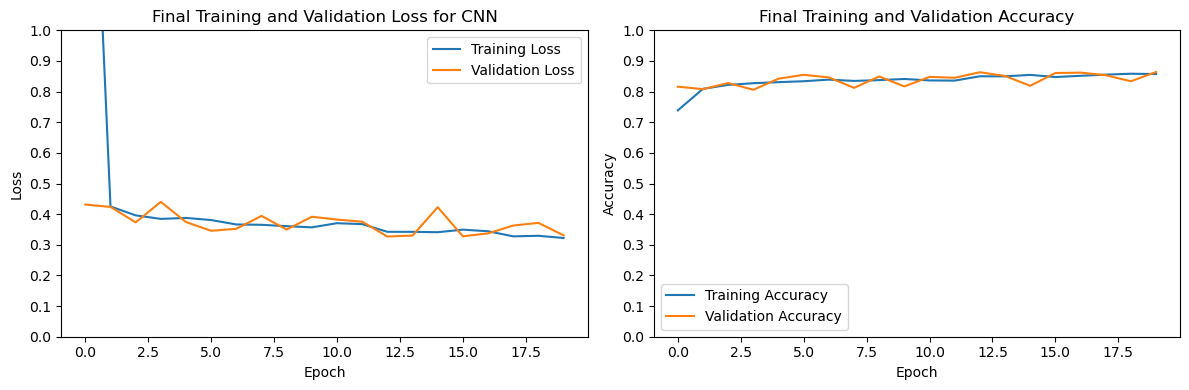

In [56]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(opt_history.history['loss'], label='Training Loss')
plt.plot(opt_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)]) 
plt.legend()
plt.title('Final Training and Validation Loss for CNN')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(opt_history.history['accuracy'], label='Training Accuracy')
plt.plot(opt_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)]) 
plt.legend()
plt.title('Final Training and Validation Accuracy')

plt.tight_layout()
plt.show()

The plot above shows significant variance in the validation set, roughly averaging around the same accuracy and loss after the 1st epoch. This means that further epoch will not improve accuracy significantly.

In [58]:
print(true_classes.shape)
print(opt_predicted_classes.shape)

(2000,)
(2000,)


Sequential Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1000
           1       0.49      0.45      0.47      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



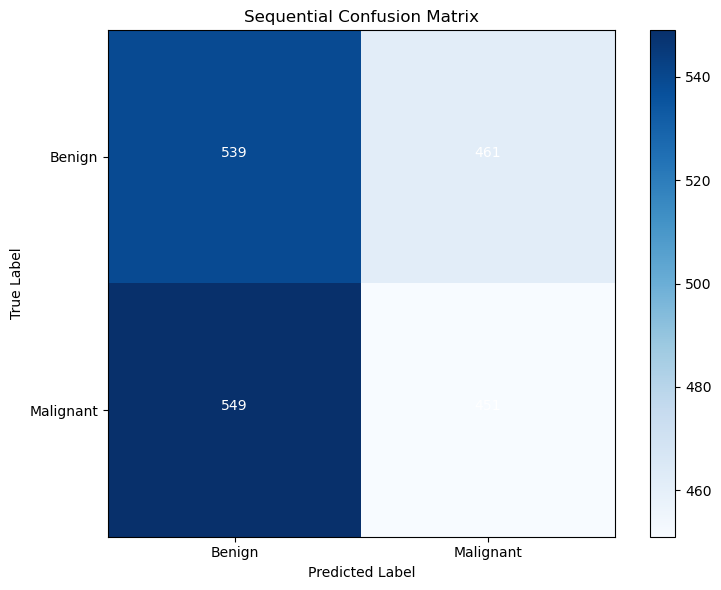

In [57]:
# Print the classification report
print("Sequential Classification Report:")
print(classification_report(true_classes, opt_predicted_classes))

# Plot the confusion matrix
opt_cm = confusion_matrix(true_classes, opt_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(opt_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Sequential Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values inside the squares
thresh = opt_cm.max() / 2.
for i in range(opt_cm.shape[0]):
    for j in range(opt_cm.shape[1]):
        plt.text(j, i, format(opt_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if opt_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The confusion matrix was plotted above shows irregularities in the data. I'm unsure of exactly why the test_generator.classes did not add up to 2000. Alongside the poor accuracy scoring, I deduced that the confusion matrix does not accurately assess the model, and hence I will be using test & validation accuracy as a metric for comparison.

## Conclusions

With a slightly higher validation accuracy but a worse test accuracy, it can be concluded that the hyperparameter tuning was ineffective at improving the model. With that being said, the model performing at 88% accuracy is sufficient enough and is more than effective at distinguishing between benign and malignant tumors. Should the time permit, additional improvements by increasing hyperparameters such as batchsize should be explored to see if improvements can be made from other aspects.

#